In [48]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import cv2
import time
import seaborn as sns
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast

In [49]:
# Define the DatasetCreator at the top level
class DatasetCreator(Dataset):
    def __init__(self, spec_path, labels_path, image_size, channels=3):
        self.df = pd.read_csv(labels_path, index_col=0)
        self.df['tool'] = self.df.index.map(lambda id: f'{spec_path}/tool/{id}.jpg')
        self.image_size = image_size
        self.channels = channels

    def __get_df__(self):
        return self.df

    def __len__(self):
        return len(self.df.index)

    def __getitem__(self, idx):
        image_path = self.df.iloc[idx]['tool']
        img = cv2.imread(image_path)
        res = cv2.resize(img, dsize=(self.image_size, self.image_size), interpolation=cv2.INTER_CUBIC)
        image_tensor = torch.tensor(res).float().permute(2, 0, 1)  # play nice with Pytorch (convert to CHW)

        label = self.df.iloc[idx]['tool_label']

        return image_tensor, label - 1

In [50]:
#fixed variables
image_size = 256 #could potentially change
channels = 3
num_classes = 3
cnn_out_channels = 64

In [51]:
#adjustable variables
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32 #changing this from 64 to 32 worked magic for some reason
num_epochs = 10

In [52]:
#init data
spec_path = "./dataset_aug"
labels_path = "./labels_aug/random_distribution" # or "./labels_aug/tool_distribution"

train_dataset = DatasetCreator(spec_path, os.path.join(labels_path, "train.csv"), image_size, channels)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)  # Set num_workers=0 for now

test_dataset = DatasetCreator(spec_path, os.path.join(labels_path, "test.csv"), image_size, channels)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

val_dataset = DatasetCreator(spec_path, os.path.join(labels_path, "val.csv"), image_size, channels)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [53]:
print(len(train_dataset), len(test_dataset), len(val_dataset))

2460 48 54


In [54]:
df_train = train_dataset.__get_df__()
df_train.head()

,image_label,tool_label,tool
id,,,
T6R1B4,sharp,1,./dataset_aug/tool/T6R1B4.jpg
T2R3B2,sharp,1,./dataset_aug/tool/T2R3B2.jpg
T9R11B1,used,2,./dataset_aug/tool/T9R11B1.jpg
T9R3B1,sharp,1,./dataset_aug/tool/T9R3B1.jpg
T6R2B4,sharp,1,./dataset_aug/tool/T6R2B4.jpg


In [55]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=3, cnn_out_channels=64):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, cnn_out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(cnn_out_channels)
        self.conv2 = nn.Conv2d(cnn_out_channels, cnn_out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(cnn_out_channels)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(cnn_out_channels * (image_size // 4) ** 2, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [56]:
#init model, loss function, optimizer
model = SimpleCNN(in_channels=channels, num_classes=num_classes, cnn_out_channels=cnn_out_channels)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scaler = GradScaler(enabled=torch.cuda.is_available())  # Only enable if CUDA is available

In [57]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")

Using cpu


In [58]:
#train and eval functions
def train(model, dataloader, optimizer, loss_func, device):
    model.train()
    model = model.to(device)
    total_loss, total_count, acc_count = 0, 0, 0

    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        with autocast(enabled=torch.cuda.is_available()):
            y_pred = model(X)
            loss = loss_func(y_pred, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        total_count += X.size(0)

        _, y_pred_class = y_pred.max(dim=1)
        acc_count += (y_pred_class == y).sum().item()

    return total_loss / total_count, acc_count / total_count

def evaluate(model, dataloader, loss_func, device):
    model.eval()
    model = model.to(device)
    total_loss, total_count, acc_count = 0, 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            with autocast(enabled=torch.cuda.is_available()):
                y_pred = model(X)
                loss = loss_func(y_pred, y)

            total_loss += loss.item()
            total_count += X.size(0)

            _, y_pred_class = y_pred.max(dim=1)
            acc_count += (y_pred_class == y).sum().item()

    return total_loss / total_count, acc_count / total_count

In [59]:
#training loop
train_loss_epochs = []
val_loss_epochs = []
train_acc_epochs = []
val_acc_epochs = []

for epoch in range(num_epochs):
    start = time.time()
    loss_train, train_acc = train(model, train_dataloader, optimizer, loss_func, device)
    loss_val, val_acc = evaluate(model, val_dataloader, loss_func, device)

    train_loss_epochs.append(loss_train)
    val_loss_epochs.append(loss_val)
    train_acc_epochs.append(train_acc)
    val_acc_epochs.append(val_acc)
    end = time.time()

    print("=" * 102)
    print(f"| Epoch {epoch+1}/{num_epochs} | time: {(end-start):.3f} | Train Loss: {loss_train:.3f} | Val Loss: {loss_val:.3f} | Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f} |")


| Epoch 1/10 | time: 134.134 | Train Loss: 0.223 | Val Loss: 0.043 | Train Acc: 0.513 | Val Acc: 0.556 |
| Epoch 2/10 | time: 131.831 | Train Loss: 0.030 | Val Loss: 0.034 | Train Acc: 0.587 | Val Acc: 0.630 |
| Epoch 3/10 | time: 132.538 | Train Loss: 0.025 | Val Loss: 0.029 | Train Acc: 0.621 | Val Acc: 0.667 |
| Epoch 4/10 | time: 131.692 | Train Loss: 0.021 | Val Loss: 0.026 | Train Acc: 0.690 | Val Acc: 0.704 |
| Epoch 5/10 | time: 131.789 | Train Loss: 0.021 | Val Loss: 0.022 | Train Acc: 0.682 | Val Acc: 0.815 |
| Epoch 6/10 | time: 131.796 | Train Loss: 0.016 | Val Loss: 0.017 | Train Acc: 0.771 | Val Acc: 0.796 |
| Epoch 7/10 | time: 132.147 | Train Loss: 0.013 | Val Loss: 0.023 | Train Acc: 0.822 | Val Acc: 0.759 |
| Epoch 8/10 | time: 133.526 | Train Loss: 0.014 | Val Loss: 0.018 | Train Acc: 0.820 | Val Acc: 0.778 |
| Epoch 9/10 | time: 133.887 | Train Loss: 0.012 | Val Loss: 0.017 | Train Acc: 0.828 | Val Acc: 0.796 |
| Epoch 10/10 | time: 132.596 | Train Loss: 0.009 | Val

In [60]:
test_loss, test_acc = evaluate(model, test_dataloader, loss_func, device)
print("Test Accuracy: ", test_acc)

Test Accuracy:  0.7916666666666666


In [61]:
#save loss and accuracy
torch.save(model.state_dict(), "./model")
torch.save(train_loss_epochs, "./train_loss_epochs.pt")
torch.save(val_loss_epochs, "./val_loss_epochs.pt")
torch.save(train_acc_epochs, "./train_acc_epochs.pt")
torch.save(val_acc_epochs, "./val_acc_epochs.pt")

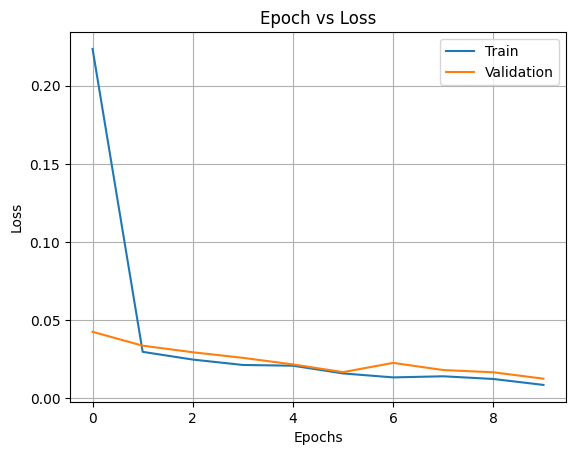

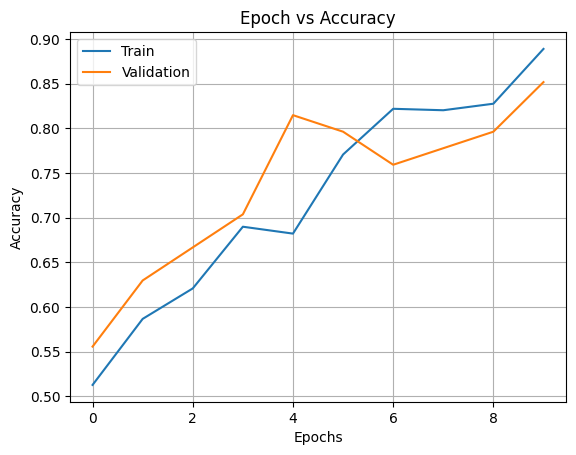

In [62]:
#plot Epoch vs. Loss
plt.plot(train_loss_epochs, label="Train")
plt.plot(val_loss_epochs, label="Validation")
plt.title("Epoch vs Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

#plot Epoch vs. Accuracy
plt.plot(train_acc_epochs, label="Train")
plt.plot(val_acc_epochs, label="Validation")
plt.title("Epoch vs Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()